In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, cross_validate
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

SEED = 314159

In [104]:
df = pd.read_csv(f"my_prepared.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,3,4,4,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,3,4,4,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,3,4,4,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,0,...,0,3,4,4,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,3,4,4,0,12,2008,8,4,250000


#### Выделите обучающую и отложенную выборку.

In [105]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### 1(a)Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора. 

In [106]:
depths = np.linspace(1, 10, 10, dtype='int') 
scores_ = []

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores_.append(np.mean(scores))

best_max_depth = depths[np.argmax(scores_)]
print(f"Best max depth: {best_max_depth}")

Best max depth: 5


#### 1(b) Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.

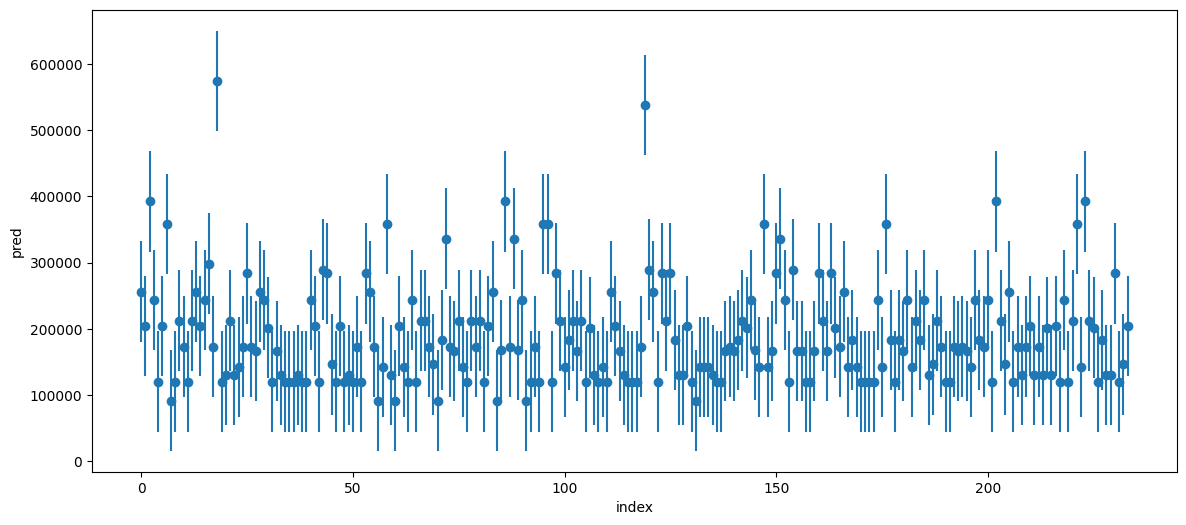

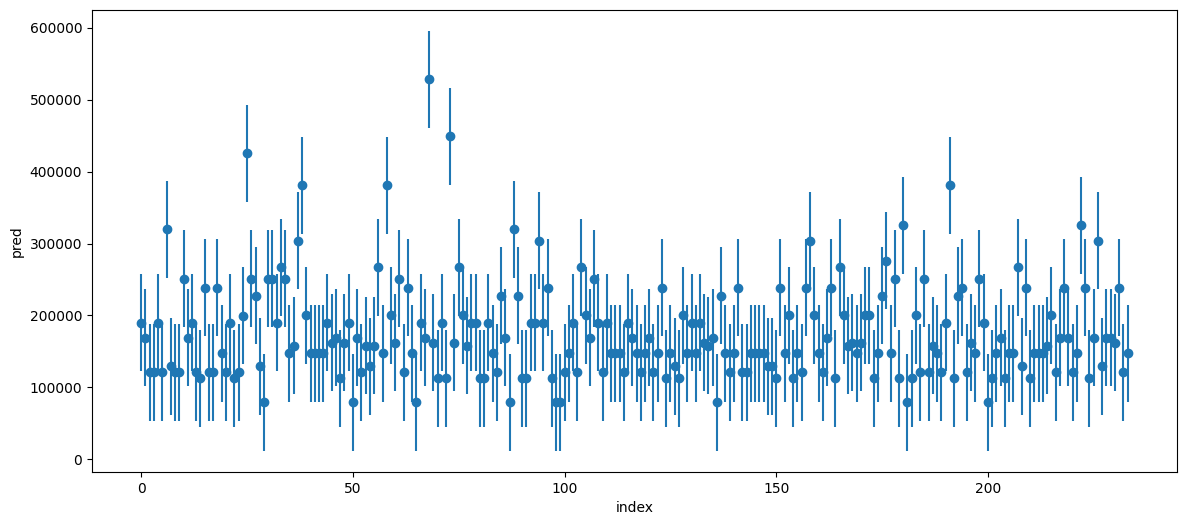

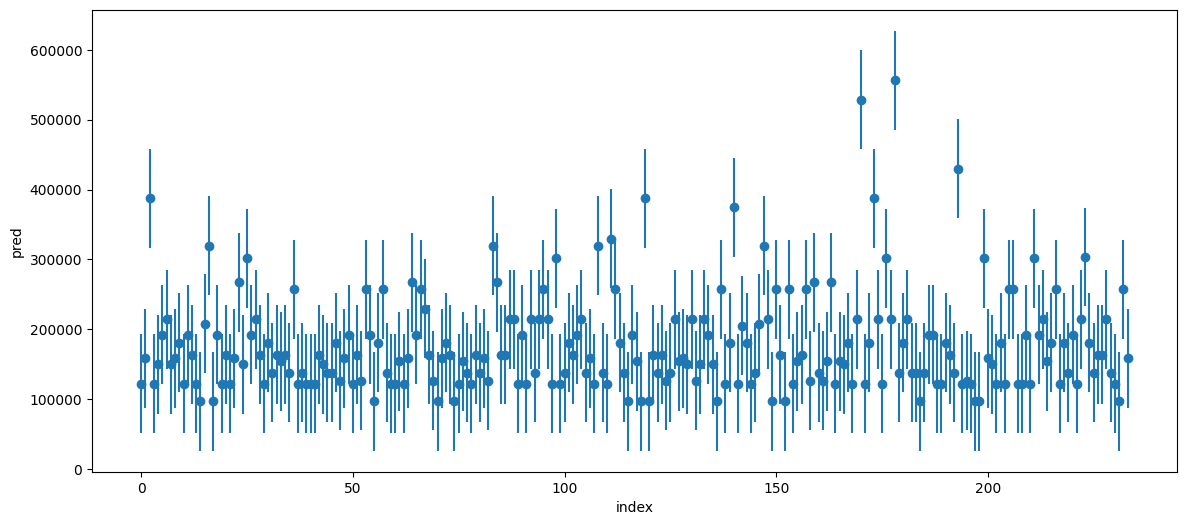

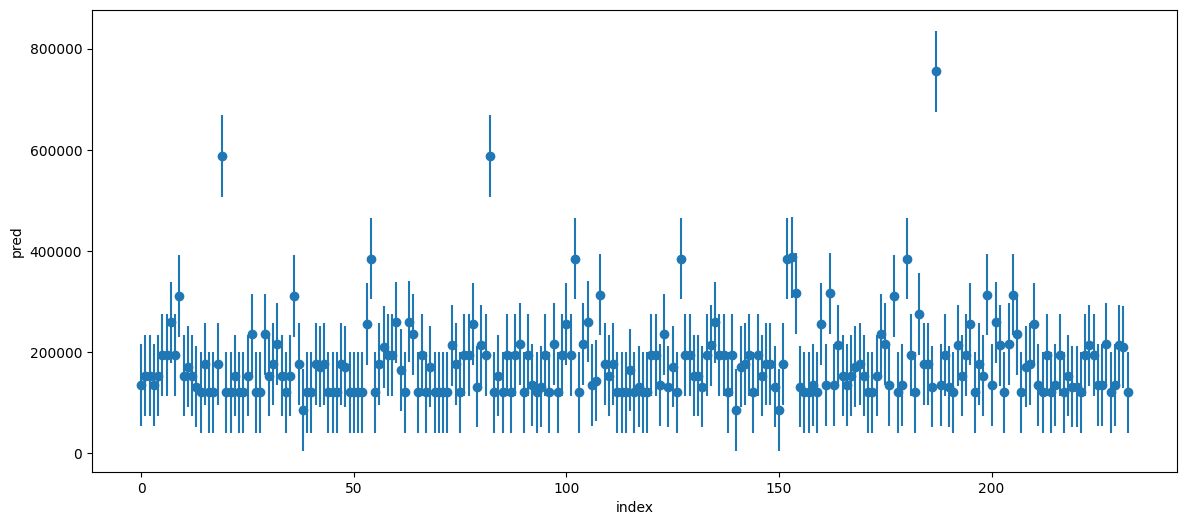

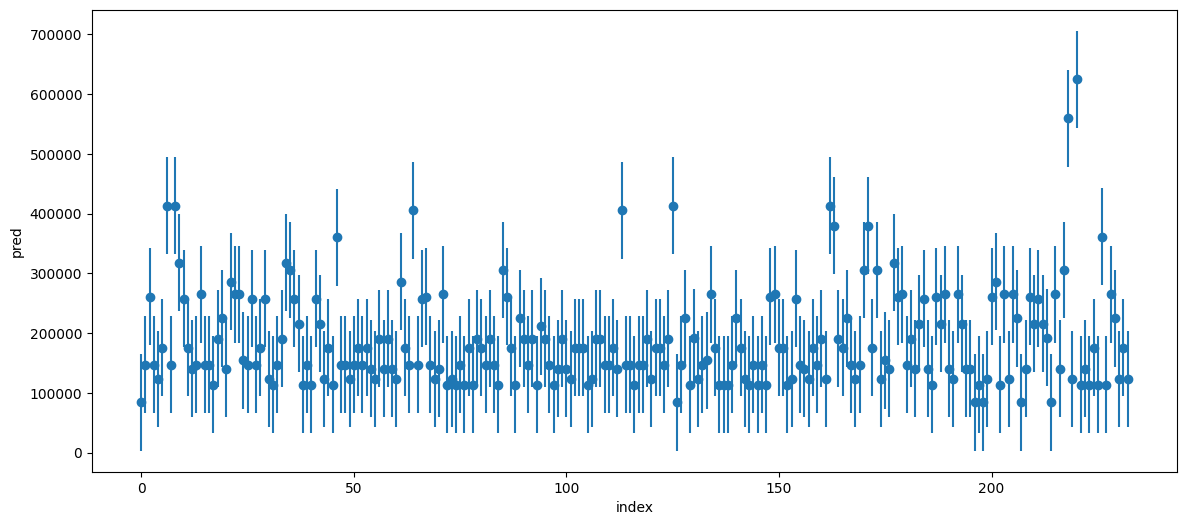

In [107]:
def plot_pred(X, y):
    dt = DecisionTreeRegressor(max_depth=best_max_depth, random_state=SEED)
    kf = KFold()

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index] 
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        fold_std = np.std(y_pred)

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.errorbar(np.arange(0, X_test.shape[0]), y_pred, yerr=fold_std, fmt='o')
        ax.set_xlabel('index')
        ax.set_ylabel('pred')
        plt.show()

plot_pred(X_train, y_train)

#### 1(c)Постройте зависимость точности (+/- 2 стандартных отклонения) от глубины деревьев

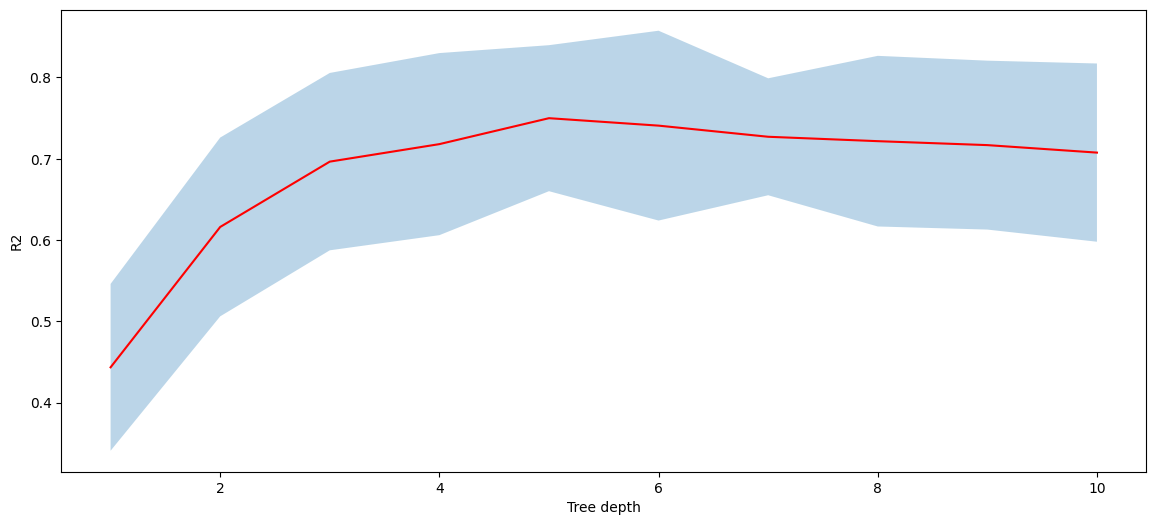

In [108]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
        #scores = cross_val_score(dt, X, y, cv=5, scoring='neg_mean_squared_error')
        scores = cross_val_score(dt, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

#### 1(d)Визуализируйте предсказания на отложенной выборке. Можно ли получить интервальные предсказания и для нее?

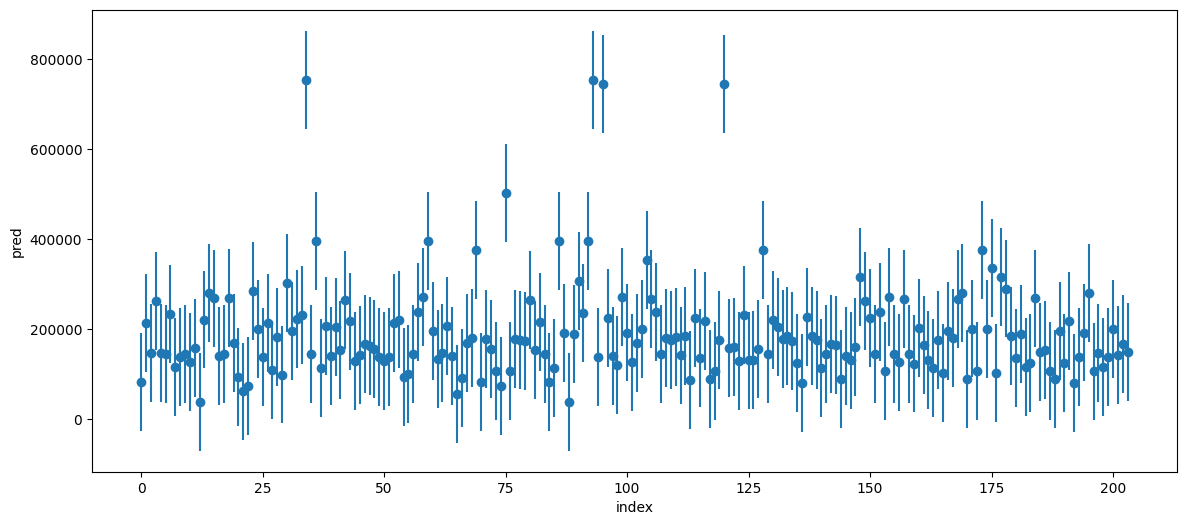

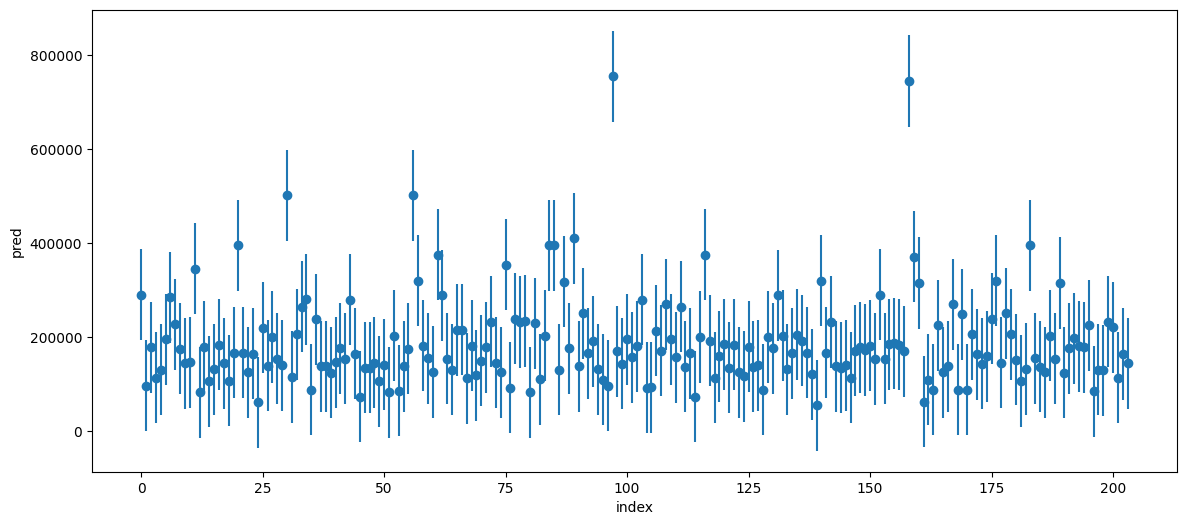

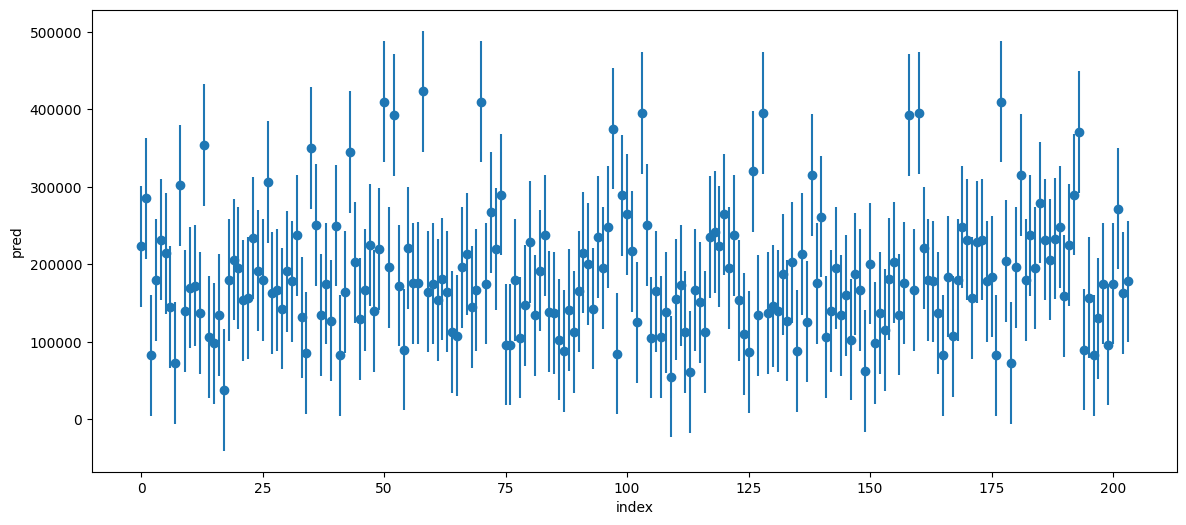

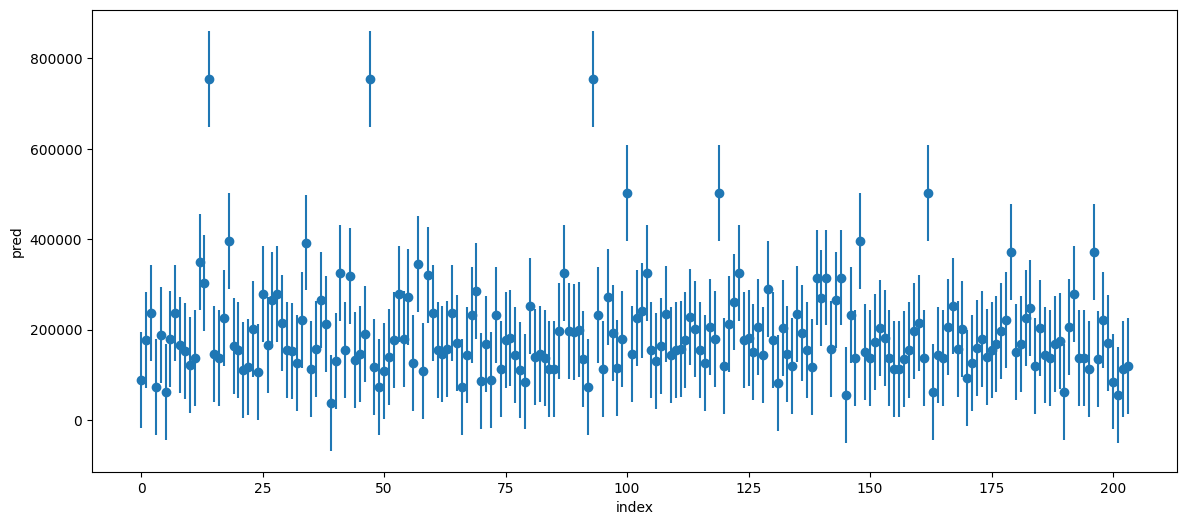

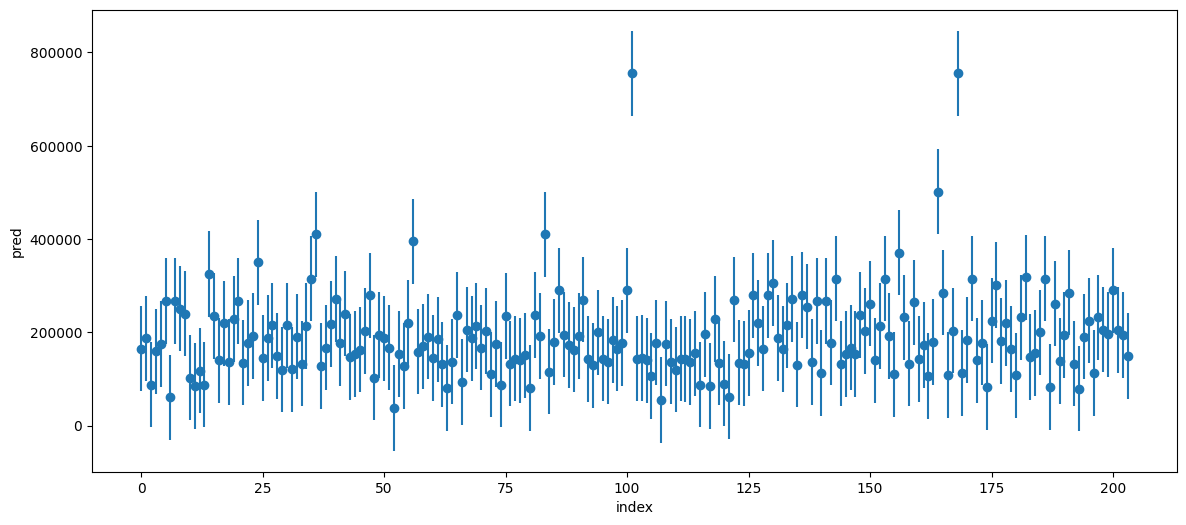

In [109]:
def plot_pred(X_test, y_test, est):

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    for i in range(5):
        sample_idx = X_test.sample(frac=0.7, random_state=SEED+i, replace=True).index 
        X_test_cv = X_test.iloc[sample_idx,  :]
        y_test_cv = y_test[sample_idx]

        y_pred = est.predict(X_test_cv)
        fold_std = np.std(y_pred)

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.errorbar(np.arange(0, X_test_cv.shape[0]), y_pred, yerr=fold_std, fmt='o')
        ax.set_xlabel('index')
        ax.set_ylabel('pred')
        plt.show()

plot_pred(X_test, y_test, DecisionTreeRegressor().fit(X_train, y_train))

#### 2(a)Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [110]:
dt = DecisionTreeRegressor()
trees = cross_validate(estimator=dt, X=X_train, y=y_train, cv=5, scoring='r2', return_estimator=True)
trees

{'fit_time': array([0.03959274, 0.03607798, 0.02449536, 0.02231312, 0.02466178]),
 'score_time': array([0.00267673, 0.00217056, 0.00150752, 0.00163817, 0.0018816 ]),
 'estimator': [DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor()],
 'test_score': array([0.73455418, 0.61886156, 0.64070695, 0.7678394 , 0.68148217])}

Tree 0 r2 score: 0.7016197679108966
Tree 1 r2 score: 0.36348984855894095
Tree 2 r2 score: 0.2772415547647644
Tree 3 r2 score: 0.7302283051217877
Tree 4 r2 score: 0.43489005944592674
Tree 5 r2 score: 0.5228515682508145
Tree 6 r2 score: 0.3710156194288232
Tree 7 r2 score: 0.6516472873333512
Tree 8 r2 score: 0.6581042948950104
Tree 9 r2 score: 0.4094726357773748
Ensemble r2 score: 0.47822431358101924


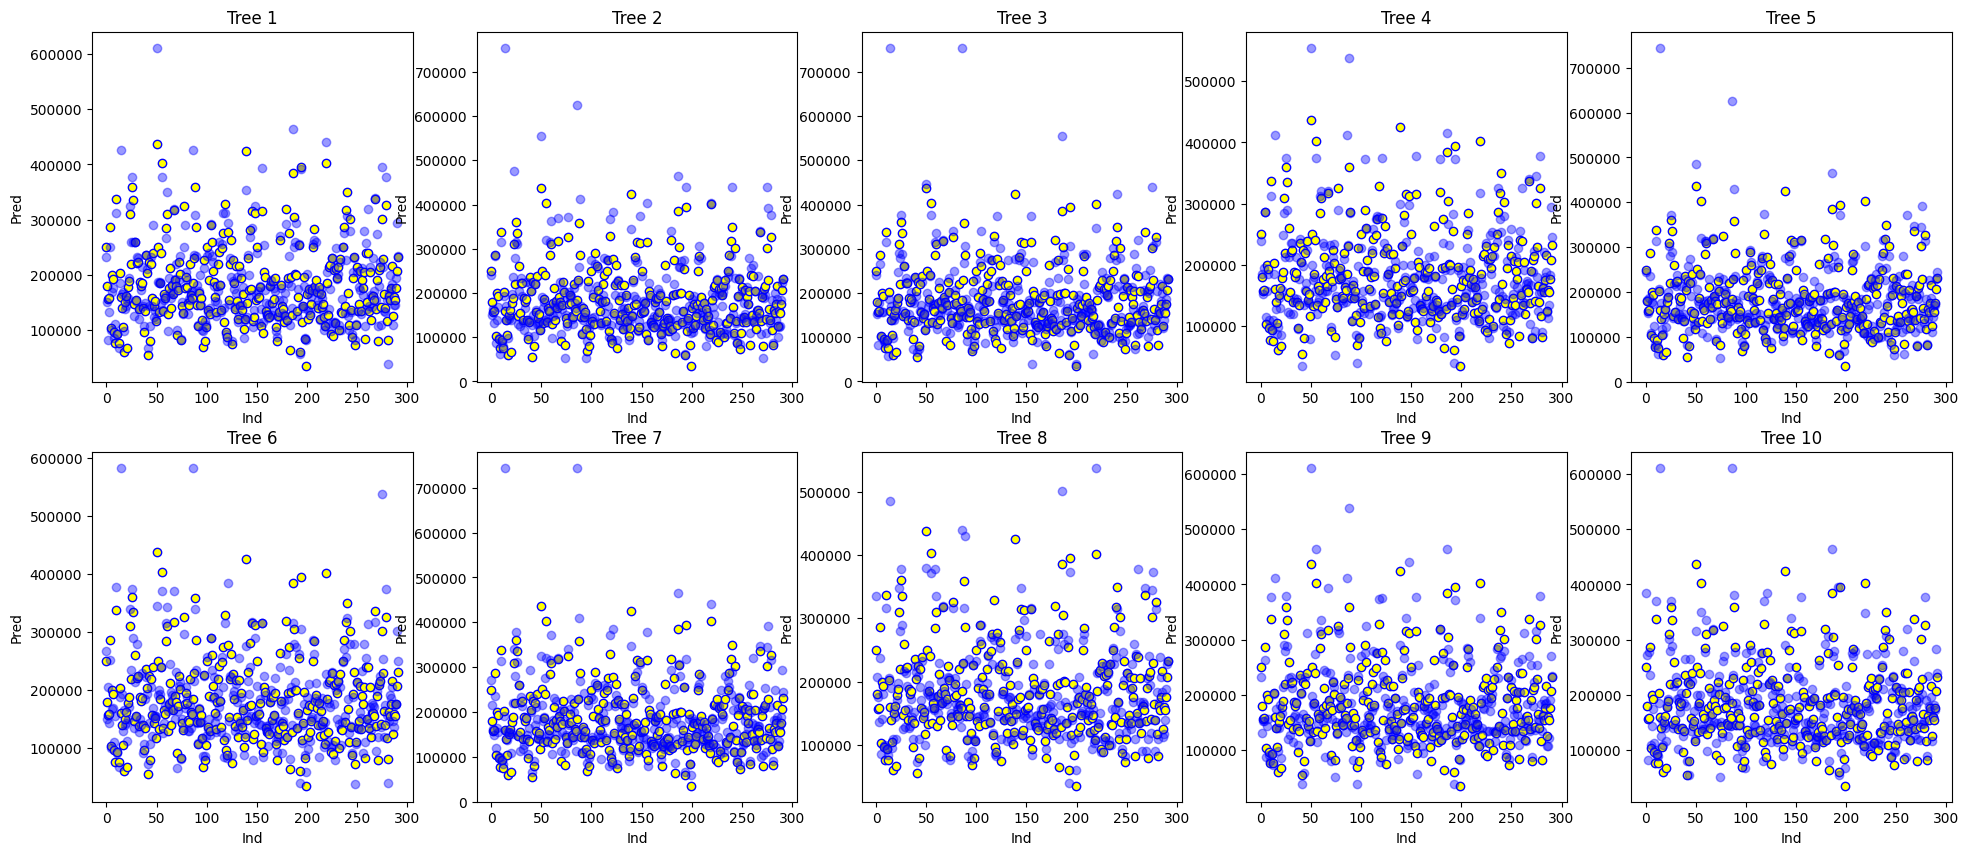

In [111]:
trees = []
individual_r2_scores = []
n_trees = 10

dt = DecisionTreeRegressor()
trees_ = cross_validate(estimator=dt, X=X_train, y=y_train, cv=10, scoring='r2', return_estimator=True)

for i in range(n_trees):
    r_sq = trees_['estimator'][i].score(X_test, y_test)
    trees.append(dt)
    print(f'Tree {i} r2 score: {r_sq}')

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))  # Adjust number of rows and columns based on n_trees
axes = axes.flatten()

for i, tree in enumerate(trees):
    y_pred = trees_['estimator'][i].predict(X_test)
    erros = y_pred - y_test
    std_errors = np.std(erros)
    ax = axes[i]
    ax.scatter(np.arange(0, X_test.shape[0]), y_test, color='yellow', alpha=1, edgecolors='b')
    ax.scatter(np.arange(0, X_test.shape[0]), y_pred, color='blue', alpha=0.4, edgecolors='b')
    # ax.fill_between(np.arange(0, X_test.shape[0]), 
    #                 erros - np.array(std_errors), 
    #                 erros + np.array(std_errors), 
    #                 alpha=0.3)
    
    ax.set_xlabel('Ind')
    ax.set_ylabel('Pred')
    ax.set_title(f'Tree {i+1}')

estimators = [(f'tree_{i}', trees_['estimator'][i]) for i in range(n_trees)]
ensemble = VotingRegressor(estimators=estimators).fit(X_train, y_train)
r_sq = ensemble.score(X_test, y_test)
print(f'Ensemble r2 score: {r_sq}')

#### 2(b)Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [112]:
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=n_trees,
    random_state=SEED,
    n_jobs=-1
).fit(X_train, y_train)

r_sq = bagging.score(X_test, y_test)
print(f'Bagging r2 score: {r_sq}')

Bagging r2 score: 0.5926880224421371


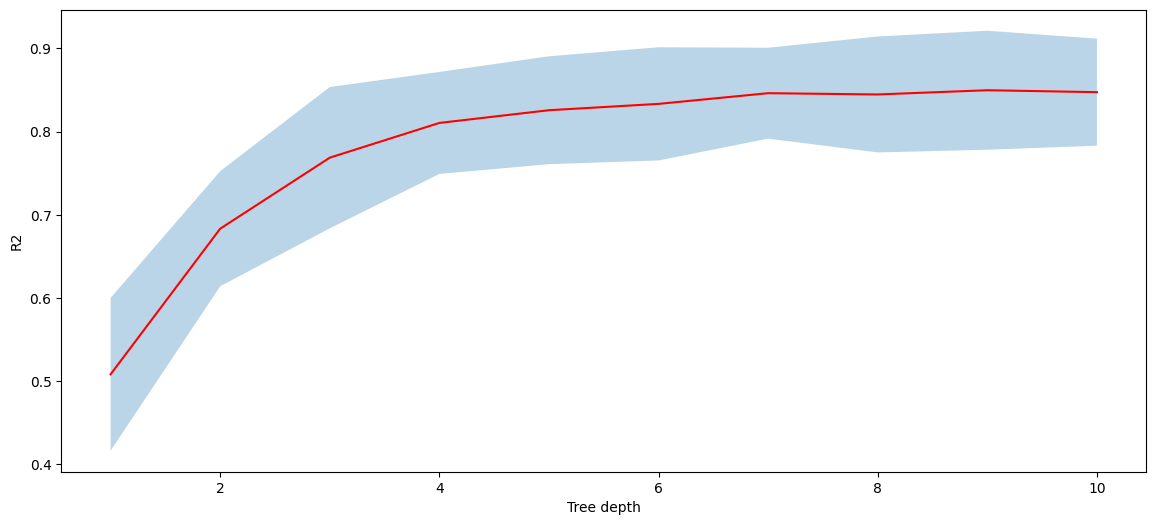

In [113]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        bagging = BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=depth),
            n_estimators=n_trees,
            random_state=SEED
        )
        scores = cross_val_score(bagging, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

#### 2(c)Постройте графики зависимости bias-variance в зависимости от числа деревьев.

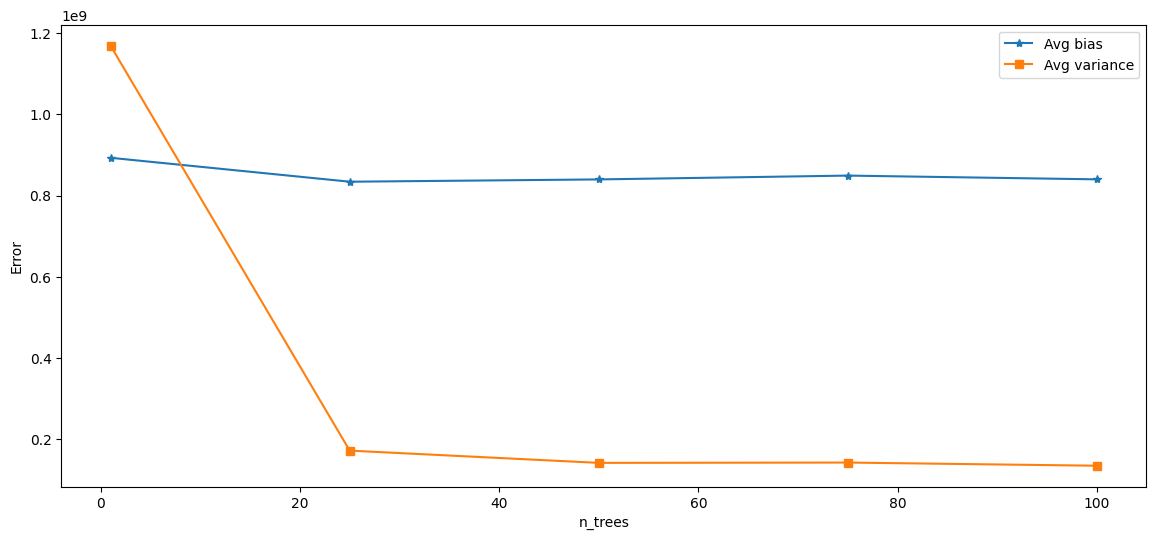

In [114]:
def plot_bias_variance_error_with_cv(X, y):
    n_trees = np.linspace(1, 100, 5, dtype='int')
    errors = []
    biases = []
    variances = []
    kf = KFold()

    X = X.values  
    y = y.values 

    for n_tree in n_trees:
        bagging = BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=7),
            n_estimators=n_tree,
            random_state=SEED,
            n_jobs=-1
        )

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X):
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                bagging, X_train, y_train, X_test, y_test, loss='mse',
                num_rounds=25
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    #ax.plot(n_trees, errors, label='Avg_loss', marker='o')
    ax.plot(n_trees, biases, label='Avg bias', marker='*')
    ax.plot(n_trees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('n_trees')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()

plot_bias_variance_error_with_cv(X_train, y_train)

#### 3 Повторите предыдущие шаги, но для случайного леса.

In [115]:
rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=SEED,
    max_depth=8,
    oob_score=True,
).fit(X_train, y_train)

r_sq = rf.score(X_test, y_test)
print(f'Random forest r2 score: {r_sq}')
print(f'Random forest oob score: {rf.oob_score_}')

Random forest r2 score: 0.6464556420865601
Random forest oob score: 0.8782569744405145


In [116]:
rfs_ = cross_validate(estimator=rf, X=X_train, y=y_train, cv=10, scoring='r2', return_estimator=True)
a = np.mean(rfs_['test_score'])
print(f'Random forest r2 score: {a}')

Random forest r2 score: 0.8635933626601874


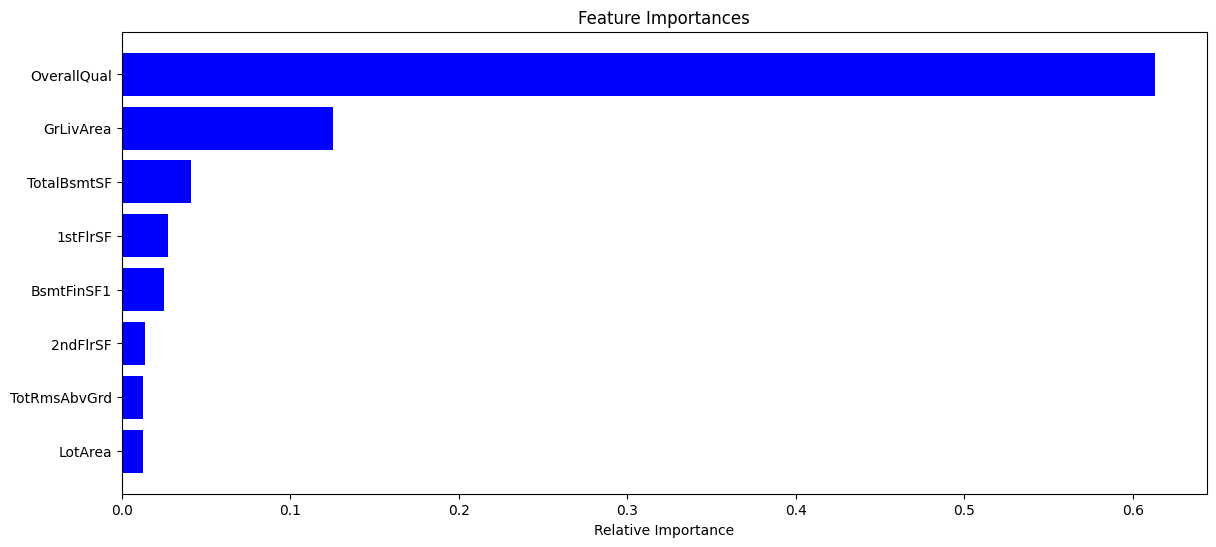

In [117]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
 
num_features = 8 

plt.figure(figsize=(14,6))
plt.title('Feature Importances')

plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [118]:
X0=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF']]
X1=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1']]
X2=df[['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', '2ndFlrSF', 'TotRmsAbvGrd', 'LotArea']]
y = df['SalePrice']
X=[X0, X1, X2]

for i in range(len(X)):
       X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=SEED)
       rf = RandomForestRegressor(
              n_estimators=n_trees, 
              random_state=SEED
       ).fit(X_train, y_train)

       r_sq = rf.score(X_test, y_test)
       print(f'Random forest r2 for X{i} important features: {r_sq}')

Random forest r2 for X0 important features: 0.399500582107188
Random forest r2 for X1 important features: 0.4623271935408775
Random forest r2 for X2 important features: 0.5226775640148352


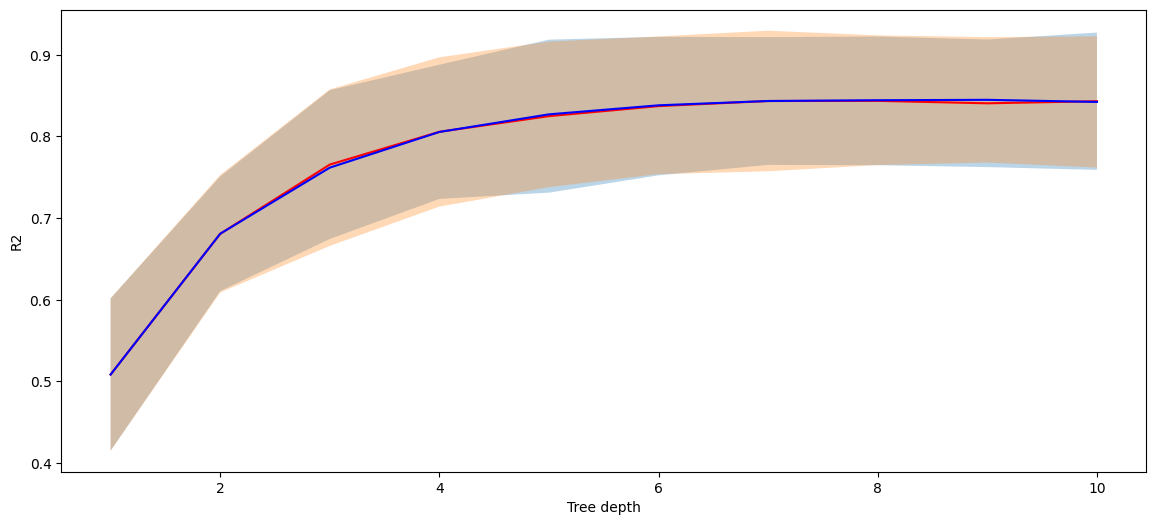

In [119]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    mean_scores2 = []
    std_scores2 = []

    for depth in depths:
        rf = RandomForestRegressor(
            n_estimators=n_trees, 
            random_state=SEED,
            max_depth=depth
        )

        bagging = BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=depth),
            n_estimators=n_trees,
            random_state=SEED
        )

        scores1 = cross_val_score(rf, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores1))
        std_scores.append(np.std(scores1))

        scores2 = cross_val_score(bagging, X, y, cv=5, scoring='r2')
        mean_scores2.append(np.mean(scores2))
        std_scores2.append(np.std(scores2))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.plot(depths, mean_scores2, color='blue')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)
    
    ax.fill_between(depths, 
                    mean_scores2 - 2 * np.array(std_scores2), 
                    mean_scores2 + 2 * np.array(std_scores2), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

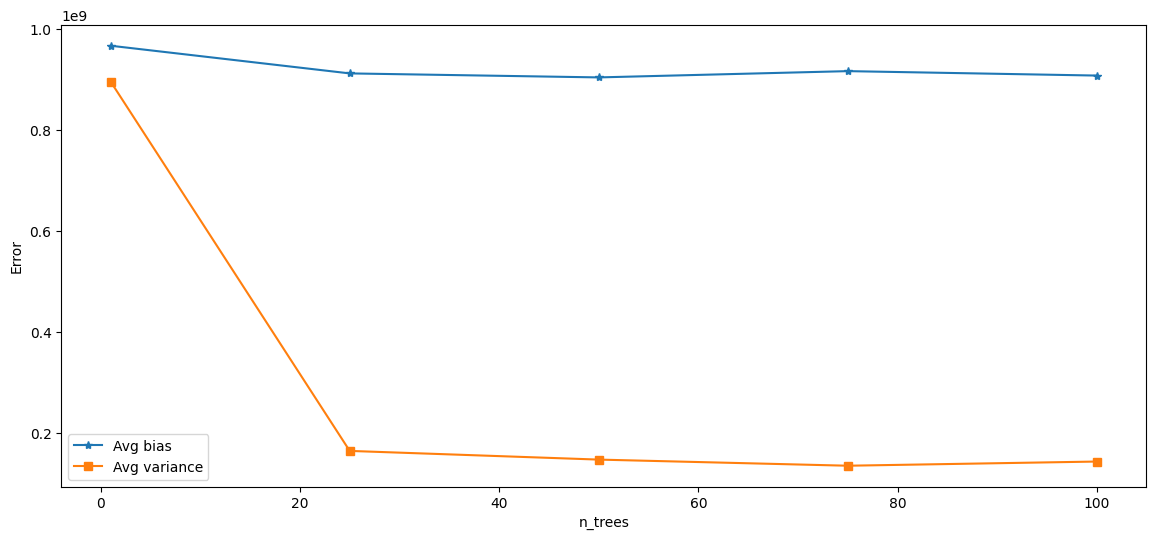

In [120]:
def plot_bias_variance_error_with_cv(X, y):
    n_trees = np.linspace(1, 100, 5, dtype='int')
    errors = []
    biases = []
    variances = []
    kf = KFold()

    X = X.values  
    y = y.values 

    for n_tree in n_trees:
        rf = RandomForestRegressor(
            n_estimators=n_tree, 
            random_state=SEED,
            max_depth=8,
            n_jobs=-1
        )

        errors_ = []
        biases_ = []
        variances_ = []

        for train_index, test_index in kf.split(X):
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            error, bias, var = bias_variance_decomp(
                rf, X_train, y_train, X_test, y_test, loss='mse',
                num_rounds=25
            ) 
            
            errors_.append(error)
            biases_.append(bias)
            variances_.append(var)

        errors.append(np.mean(errors_))
        biases.append(np.mean(biases_))
        variances.append(np.mean(variances_))

    fig, ax = plt.subplots(figsize=(14, 6))
    #ax.plot(n_trees, errors, label='mse', marker='o')
    ax.plot(n_trees, biases, label='Avg bias', marker='*')
    ax.plot(n_trees, variances, label='Avg variance', marker='s')
    ax.set_xlabel('n_trees')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()

plot_bias_variance_error_with_cv(X_train, y_train)

#### 5 AdaBoost

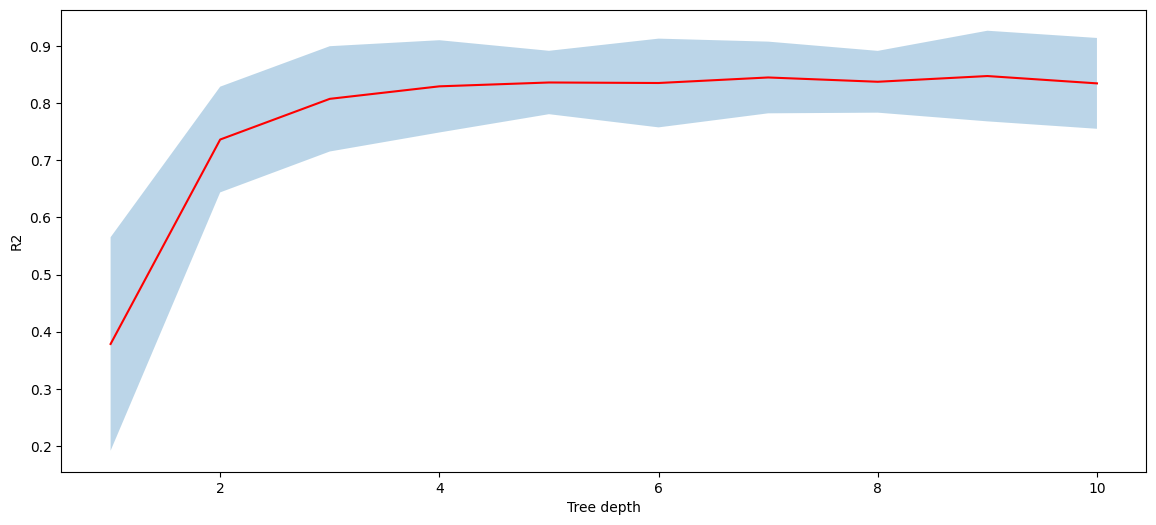

In [121]:
def plot_depth_score(X, y):
    depths= np.linspace(1, 10, 10, dtype='int') 

    mean_scores = []
    std_scores = []

    for depth in depths:
        ab = AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=depth),
            n_estimators=n_trees, 
            random_state=SEED,
        )

        scores = cross_val_score(ab, X, y, cv=5, scoring='r2')
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(depths, mean_scores, color='red')
    ax.fill_between(depths, 
                    mean_scores - 2 * np.array(std_scores), 
                    mean_scores + 2 * np.array(std_scores), 
                    alpha=0.3)

    ax.set_xlabel('Tree depth')
    ax.set_ylabel('R2')
    plt.show()

plot_depth_score(X_train, y_train)

In [122]:
ab = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=7),
    n_estimators=n_trees, 
    random_state=SEED,
).fit(X_train, y_train)

r_sq = ab.score(X_test, y_test)
print(f'AdaBoost DecisionTreeRegressor r2 score: {r_sq}')

AdaBoost DecisionTreeRegressor r2 score: 0.41575334323275315


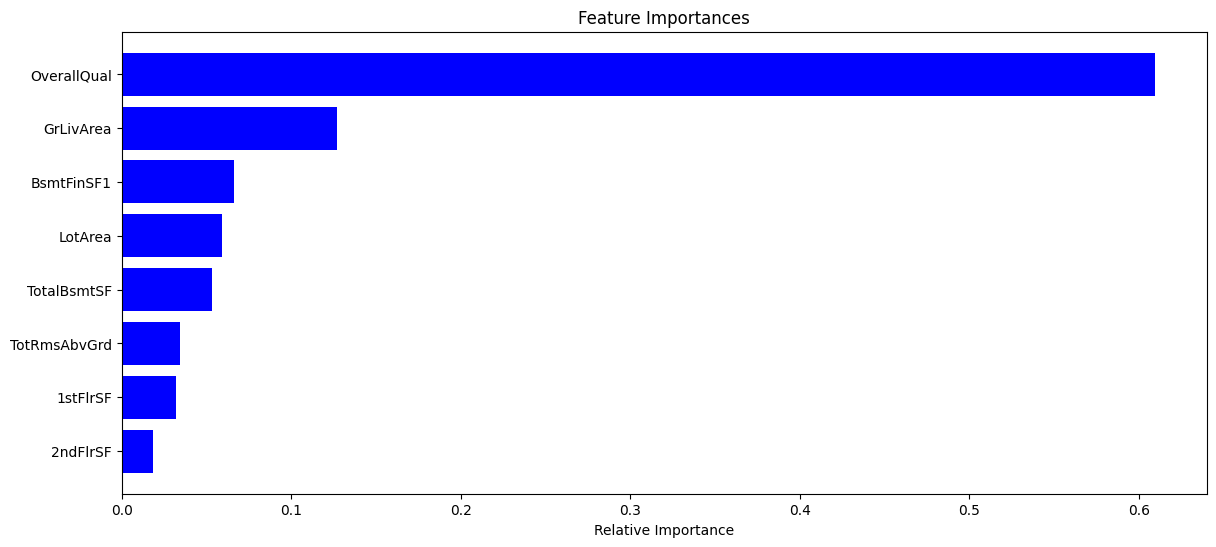

In [123]:
features = X_train.columns
importances = ab.feature_importances_
indices = np.argsort(importances)
 
num_features = 8 

plt.figure(figsize=(14,6))
plt.title('Feature Importances')

plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [124]:
X0=df[['OverallQual', 'GrLivArea', 'BsmtFinSF1']]
X1=df[['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'LotArea', 'TotalBsmtSF']]
X2=df[['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'LotArea', 'TotalBsmtSF', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF']]
y = df['SalePrice']
X=[X0, X1, X2]
for i in range(len(X)):
       X_train, X_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=SEED)
       ab = AdaBoostRegressor(
              estimator=DecisionTreeRegressor(max_depth=7),
              n_estimators=n_trees, 
              random_state=SEED,
       ).fit(X_train, y_train)

       r_sq = ab.score(X_test, y_test)
       print(f'Random forest r2 for X{i} important features: {r_sq}')

Random forest r2 for X0 important features: 0.3888931884112783
Random forest r2 for X1 important features: 0.42098401178045686
Random forest r2 for X2 important features: 0.6621398581741695
